I will build a Blog application that allows users to create, edit, and delete posts. The homepage will list all blog posts and there will be a dedicated detail page for each individual blog post. We’ll also introduce CSS for styling and learn how Django works with static files.

our steps for setting up a new Django project are as follows:
• create a new directory for our code on the Desktop called blog

• install Django in a new virtual environment

• createanewDjangoprojectcalledconfig

• createanewappblog

• perform a migration to set up the database •

updateconfig/settings.py

In [ ]:
$ cd ~/Desktop
$ mkdir blog
$ cd blog
$ pipenv install django~=3.1.0
$ pipenv shell
(blog) $ django-admin startproject config .
(blog) $ python manage.py startapp blog
(blog) $ python manage.py migrate
(blog) $ python manage.py runserver

To ensure Django knows about our new app, open your text editor and add the new app to INSTALLED_APPS in our config/settings.py file:

In [ ]:
# config/settings.py
INSTALLED_APPS =
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',
    'django.contrib.messages',
    'django.contrib.staticfiles',
    'blog', # new
]

If you navigate to http://127.0.0.1:8000/ in your browser you should see Django welcome page

# Database Models

In our case, let’s keep things simple and assume each post has a title, author, and body. We can turn this into a database model by opening the blog/models.py file and entering the code below:

In [ ]:
# blog/models.py
from django.db import models

class Post(models.Model):
    title = models.CharField(max_length=200)
    author = models.ForeignKey(
        'auth.User',
        on_delete=models.CASCADE,
    )
    body = models.TextField()
    def __str__(self):
        return self.title

At the top, we’re importing the class models and then creating a subclass of models.Model called Post. Using this subclass functionality we automatically have access to everything within django.db.models.Models79 and can add additional fields and methods as desired.

For title we’re limiting the length to 200 characters and for body we’re using a TextField which will automatically expand as needed to fit the user’s text. There are many field types available in Django; you can see the full list here80.

For the author field we’re using a ForeignKey81 which allows for a many-to-one relationship. This means that a given user can be the author of many different blog posts but not the other way around. The reference is to the built-in User model that Django provides for authentication. For all many-to-one relationships such as a ForeignKey we must also specify an on_delete82 option

Now that our new database model is created we need to create a new migration record for it and migrate the change into our database. Stop the server with Control+c. This two-step process can be completed with the commands below:

In [ ]:
(blog) $ python manage.py makemigrations blog
(blog) $ python manage.py migrate blog

Our database is configured.

# Admin

We need a way to access our data. Enter the Django admin! First, create a superuser account by typing the command below and following the prompts to set up an email and password. Note that when typing your password, it will not appear on the screen for security reasons.

In [ ]:
(blog) $ python manage.py createsuperuser
Username (leave blank to use 'wsv'): wsv
Email:
Password:
Password (again):
Superuser created successfully.

Now start running the Django server again with the command python manage.py runserver and navigate over to the admin at 127.0.0.1:8000/admin/. Log in with your new superuser account.
Oops! Where’s our new Post model?

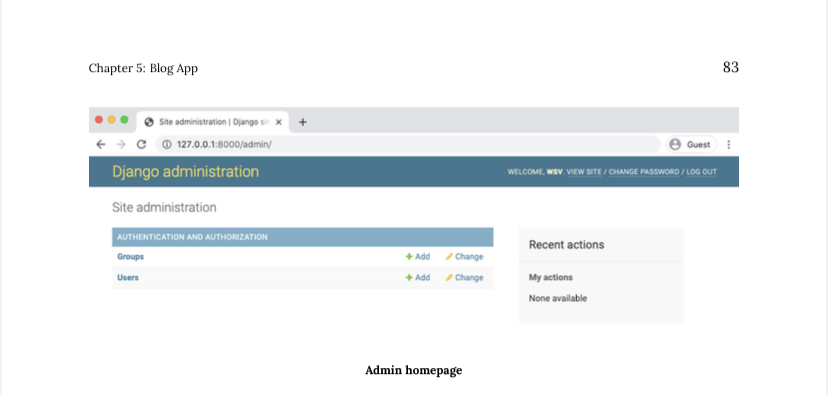

We forgot to update blog/admin.py so let’s do that now.

In [ ]:
# blog/admin.py
from django.contrib import admin
from .models import Post


admin.site.register(Post)

If you refresh the page you’ll see the update.

Let’s add two blog posts so we have some sample data to work with. Click on the + Add button next to Posts to create a new entry. Make sure to add an “author” to each post too since by default all model fields are required.

If you try to enter a post without an author you will see an error. If we wanted to change this, we could add field options83 to our model to make a given field optional or fill it with a default value.

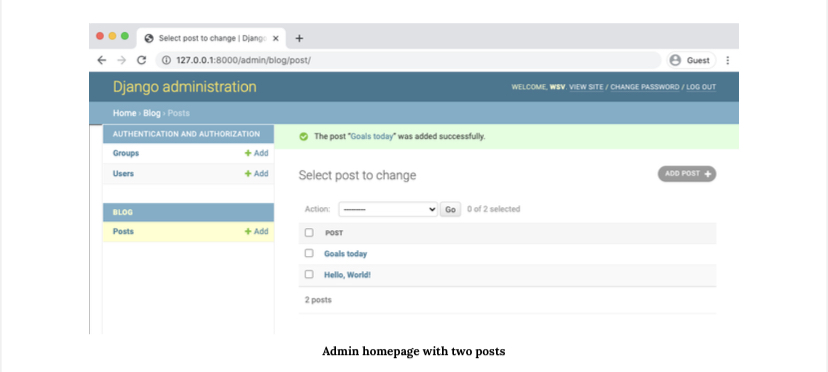

Now that our database model is complete we need to create the necessary views, URLs, and templates so we can display the information on our web application.

# URLs

We want to display our blog posts on the homepage so, as in previous chapters, we’ll first configure our config/urls.py file and then our app-level blog/urls.py file to achieve this.

On the command line quit the existing server with Control+c and create a new urls.py file within our blog:

In [ ]:
(blog) $ touch blog/urls.py

In [ ]:
# blog/urls.py
from django.urls import path
from .views import BlogListView

urlpatterns = [
    path('', BlogListView.as_view(), name='home'),
]

We’re importing our soon-to-be-created views at the top. The empty string, '', tells Python to match all values and we make it a named URL, home, which we can refer to in our views later on. While it’s optional to add a named URL84 it’s a best practice you should adopt as it helps keep things organized as your number of URLs grows.

We also should update our config/urls.py file so that it knows to forward all requests directly to the blog app.

In [ ]:
# config/urls.py
from django.contrib import admin
from django.urls import path, include # new

urlpatterns = [
    path('admin/', admin.site.urls),
    path('', include('blog.urls')), # new
]

We’ve added include on the second line and a URLpattern using an empty string regular expression, '', indicating that URL requests should be redirected as is to blog’s URLs for further instructions.

# Views

In our views file, add the code below to display the contents of our Post model using ListView.

In [ ]:
# blog/views.py
from django.views.generic import ListView
from .models import Post

class BlogListView(ListView):
  model = Post
  template_name = 'home.html'

On the top two lines we import ListView86 and our database model Post. Then we subclass ListView and add links to our model and template. This saves us a lot of code versus imple- menting it all from scratch.

# Templates

With our URLConfs and views now complete, we’re only missing the third piece of the puzzle: templates.

As we already saw before, we can inherit from other templates to keep our code clean. Thus we’ll start off with a base.html file and a home.html file that inherits from it. Then later when we add templates for creating and editing blog posts, they too can inherit from base.html.
Start by creating our new templates directory with the two template files.

In [ ]:
(blog) $ mkdir templates
(blog) $ touch templates/base.html
(blog) $ touch templates/home.html

Then update config/settings.py so Django knows to look there for our templates.

In [ ]:
# config/settings.py
TEMPLATES = [
    {
        ...
        'DIRS': [str(BASE_DIR.joinpath('templates'))], # new
        ...
    },
]

Then update the base.html template as follows.

In [ ]:
<!-- templates/base.html -->
<html>
   <head>
      <title>Django blog</title>
   </head>
   <body>
       <header>
         <h1><a href="{% url 'home' %}">Django blog</a></h1>
       </header>
    <div>
      {% block content %}
      {% endblock content %}
      </div>
   </body>
</html>

Note that code between {% block content %} and {% endblock content %} can be filled by other templates. Speaking of which, here is the code for home.html.

In [ ]:
<!-- templates/home.html -->
{% extends 'base.html' %}

{% block content %}

  {% for post in object_list %}
       <div class="post-entry">
        <h2><a href="">{{ post.title }}</a></h2>
         <p>{{ post.body }}</p>
      </div>
{% endfor %}
{% endblock content %}

At the top, we note that this template extends base.html and then wrap our desired code with content blocks. We use the Django Templating Language to set up a simple for loop for each blog post. Note that object_list comes from ListView and contains all the objects in our view.
If you start the Django server again with python manage.py runserver and refresh the homepage we can see it is working.

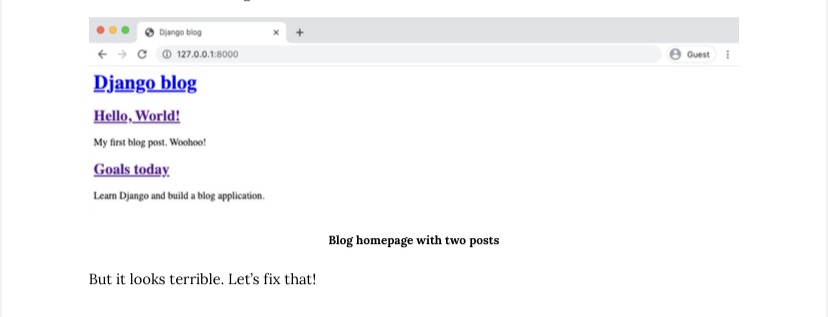

# Static Files

We need to add some CSS to our project to improve the styling. CSS, JavaScript, and images are a core piece of any modern web application and within the Django world are referred to as “static files"

Django provides tremendous flexibility around how these files are used, but this can lead to quite a lot of confusion for newcomers.

By default, Django will look within each app for a folder called static. In other words, a folder called blog/static/. If you recall, this is similar to how templates are treated as well.

As Django projects grow in complexity over time and have multiple apps, it is often simpler to reason about static files if they are stored in a single, project-level directory instead. That is the approach we will take here.


Quit the local server with Control+c and create a new directory called static in the same folder as the manage.py file.

In [ ]:
(blog) $ mkdir static

Then we need to tell Django to look for this new folder when loading static files. If you look at the bottom of the config/settings.py file, there is already a single line of configuration:

In [ ]:
# config/settings.py
STATIC_URL = '/static/'

STATIC_URL87 is the URL location of static files in our project, aka at /static/.

By configuring STATICFILES_DIRS88, we can tell Django where to look for static files beyond just app/static folder.

In your config/settings.py file, at the bottom, add the following new line which tells Django to look within our newly-created static folder for static files.

In [ ]:
# config/settings.py
STATIC_URL = '/static/'
STATICFILES_DIRS = [str(BASE_DIR.joinpath('static'))] # new

Next create a css directory within static and add a new base.css file in it.

In [ ]:
(blog) $ mkdir static/css
(blog) $ touch static/css/base.css

What should we put in our file? How about changing the title to be red?

In [ ]:
/* static/css/base.css */
header h1 a {
    color:red;
}

Last step now. We need to add the static files to our templates by adding {% load static %} to the top of base.html.

 Because our other templates inherit from base.html, we only have to add this once. Include a new line at the bottom of the <head></head> code that explicitly references our new base.css file.

In [ ]:
<!-- templates/base.html -->
{% load static %}
<html>
    <head>
       <title>Django blog</title>
        <link rel="stylesheet" href="{% static 'css/base.css' %}">
</head>
...

Now we can add static files to our static directory and they’ll automatically appear in all our templates.

Start up the server again with python manage.py runserver and look at our updated homepage
at http://127.0.0.1:8000/.

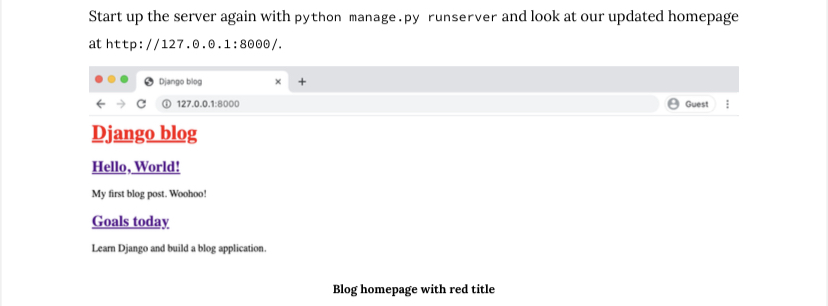

We can do a little better though. How about if we add a custom font and some more CSS? Since this book is not a tutorial on CSS simply insert the following between <head></head> tags to add Source Sans Pro89, a free font from Google.

In [ ]:
<!-- templates/base.html -->
{% load static %} <html>
<head>
<title>Django blog</title>
<link href="https://fonts.googleapis.com/css?family=Source+Sans+Pro:400" rel="styleshee\ t">
<link href="{% static 'css/base.css' %}" rel="stylesheet"> </head>
...

Then update our css file by copy and pasting the following code:

In [ ]:
/* static/css/base.css */
body {
font-family: 'Source Sans Pro', sans-serif; font-size: 18px;
}

header {
border-bottom: 1px solid #999; margin-bottom: 2rem;
display: flex;
}

header h1 a {
color: red; text-decoration: none;
}

.nav-left { margin-right: auto;
}

.nav-right { display: flex; padding-top: 2rem;
}

.post-entry { margin-bottom: 2rem;
}

.post-entry h2 { margin: 0.5rem 0;
}

.post-entry h2 a, .post-entry h2 a:visited {
color: blue;
text-decoration: none;
}

.post-entry p { margin: 0; font-weight: 400;
}

post-entry h2 a:hover { color: red;
}

Refresh the homepage at http://127.0.0.1:8000/ and you should see the following.

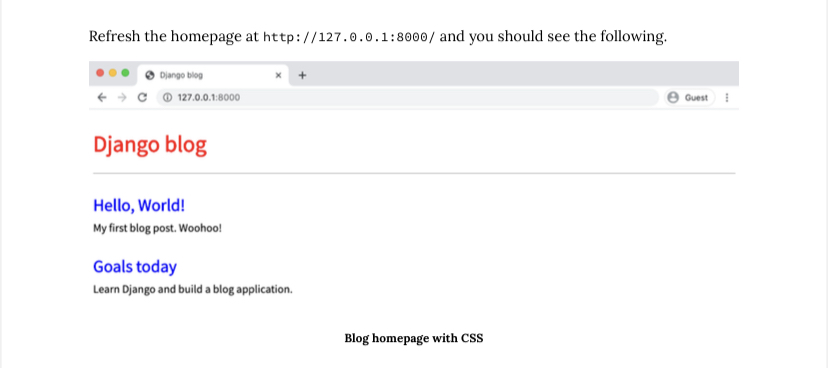

# Individual Blog Pages

Now we can add the functionality for individual blog pages. How do we do that? We need to create a new view, url, and template. I hope you’re noticing a pattern in development with Django now!
Start with the view. We can use the generic class-based DetailView90 to simplify things. At the top of the file, add DetailView to the list of imports and then create our new view called BlogDetailView.

In [ ]:
# blog/views.py
from django.views.generic import ListView, DetailView # new
from .models import Post

class BlogListView(ListView):
    model = Post
    template_name = 'home.html'

class BlogDetailView(DetailView): # new
    model = Post
    template_name = 'post_detail.html'

In this new view, we define the model we’re using, Post, and the template we want it associated with, post_detail.html. By default, DetailView will provide a context object we can use in our template called either object or the lowercased name of our model, which would be post. Also, DetailView expects either a primary key or a slug passed to it as the identifier.

Now exit the local server Control+c and create our new template for a post detail as follows:

In [ ]:
(blog) $ touch templates/post_detail.htmlg

Then type in the following code:
    

In [ ]:
<!-- templates/post_detail.html -->
{% extends 'base.html' %}
{% block content %}
    <div class="post-entry">
        <h2>{{ post.title }}</h2>
        <p>{{ post.body }}</p>
      </div>
{% endblock content %}

At the top we specify that this template inherits from base.html. Then display the title and body from our context object, which DetailView makes accessible as post.
Personally, I found the naming of context objects in generic views extremely confusing when first learning Django. Because our context object from DetailView is either our model name post or object we could also update our template as follows and it would work exactly the same.

In [ ]:
<!-- templates/post_detail.html -->
{% extends 'base.html' %}

{% block content %}

   <div class="post-entry">
      <h2>{{ object.title }}</h2>
      <p>{{ object.body }}</p>
   </div>
{% endblock content %}

If you find using post or object confusing, it’s possible to explicitly name the context object in our view using context_object_name91.
The “magic” naming of the context object is a price you pay for the ease and simplicity of using generic views, which are great if you know what they’re doing but take a little research in the official documentation to customize.
Ok, what’s next? How about adding a new URLConf for our view, which we can do as follows.

In [ ]:
# blog/urls.py
from django.urls import path
from .views import BlogListView, BlogDetailView # new

urlpatterns = [
    path('post/<int:pk>/', BlogDetailView.as_view(),
      name='post_detail'), # new
    path('', BlogListView.as_view(), name='home'),
]

All blog post entries will start with post/. Next is the primary key for our post entry which will be represented as an integer <int:pk>. What’s the primary key you’re probably asking? Django automatically adds an auto-incrementing primary key92 to our database models. So while we only declared the fields title, author, and body on our Post model, under-the-hood Django also added another field called id, which is our primary key. We can access it as either id or pk.
The pk for our first “Hello, World” post is 1. For the second post, it is 2. And so on. Therefore when we go to the individual entry page for our first post, we can expect that its urlpattern will be post/1/.

If you now start up the server with python manage.py runserver you’ll see a dedicated page for our first blog post at http://127.0.0.1:8000/post/1/.

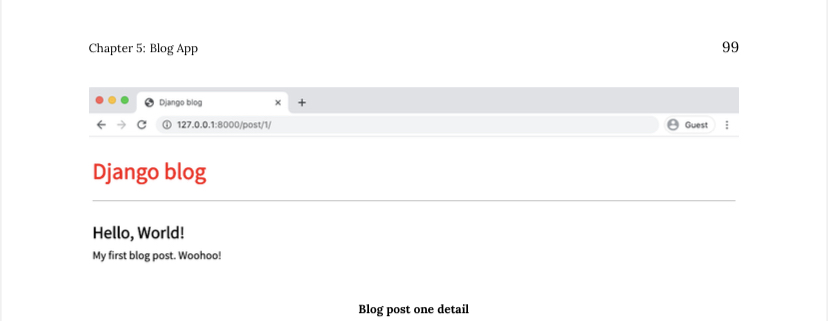

Woohoo! You can also go to http://127.0.0.1:8000/post/2/ to see the second entry.
To make our life easier, we should update the link on the homepage so we can directly access individual blog posts from there. Currently, in home.html our link is empty: <a href="">. Update it to <a href="{% url 'post_detail' post.pk %}">.

In [ ]:
<!-- templates/home.html -->
{% extends 'base.html' %}
{% block content %}
{% for post in object_list %}
   <div class="post-entry">
     <h2><a href="{% url 'post_detail' post.pk %}">{{ post.title }}</a></h2>
     <p>{{ post.body }}</p>
   </div>
  {% endfor %}
{% endblock content %}

We start off by telling our Django template we want to reference a URLConf by using the code {% url ... %}. Which URL? The one named post_detail, which is the name we gave BlogDetailView in our URLConf just a moment ago. If we look at post_detail in our URLConf, we see that it expects to be passed an argument pk representing the primary key for the blog post. Fortunately, Django has already created and included this pk field on our post object. We pass it into the URLConf by adding it in the template as post.pk.
To confirm everything works, refresh the main page at http://127.0.0.1:8000/ and click on the title of each blog post to confirm the new links work.

# TESTS

We need to test our model and views now. We want to ensure that the Post model works as expected, including its str representation. And we want to test both ListView and DetailView.

Here’s what sample tests look like in the blog/tests.py file.

In [ ]:
# blog/tests.py
from django.contrib.auth import get_user_model
from django.test import TestCase
from django.urls import reverse

from .models import Post
class BlogTests(TestCase):

     def setUp(self):
        self.user = get_user_model().objects.create_user(
            username='testuser',
            email='test@email.com',
            password='secret'
        )

        self.post = Post.objects.create(
            title='A good title',
            body='Nice body content',
            author=self.user,
        )

    def test_string_representation(self):
           post = P
           ost(title='A sample title')
           self.assertEqual(str(post), post.title)

    def test_post_content(self):
       self.assertEqual(f'{self.post.title}', 'A good title')
       self.assertEqual(f'{self.post.author}', 'testuser')
       self.assertEqual(f'{self.post.body}', 'Nice body content')

    def test_post_list_view(self):
       response = self.client.get(reverse('home'))
       self.assertEqual(response.status_code, 200)
       self.assertContains(response, 'Nice body content')
       self.assertTemplateUsed(response, 'home.html')

    def test_post_detail_view(self):
       response = self.client.get('/post/1/')
       no_response = self.client.get('/post/100000/')
       self.assertEqual(response.status_code, 200)
       self.assertEqual(no_response.status_code, 404)
       self.assertContains(response, 'A good title')
       self.assertTemplateUsed(response, 'post_detail.html')


# Git

let's initialise our directory

In [ ]:
(blog) $ git init
(blog) $ git status
(blog) $ git add -A
(blog) $ git commit -m "initial commit"



We’ve now built a basic blog application from scratch! Using the Django admin we can create, edit, or delete the content. And we used DetailView for the first time to create a detailed individual view of each blog post entry.

In the next section, Chapter 6: Blog app with forms, we’ll add forms so we don’t have to use the Django admin at all for these changes.

To start, update our base template to display a link to a page for entering new blog posts. It will
take the form <a href="{% url 'post_new' %}"></a> where post_new is the name for our URL.
Your updated file should look as follows:


In [ ]:
<!-- templates/base.html -->
{% load static %}
<html>
   <head>
      <title>Django blog</title>
      <link href="https://fonts.googleapis.com/css?family=\
      Source+Sans+Pro:400" rel="stylesheet">
      <link href="{% static 'css/base.css' %}" rel="stylesheet">
   </head>
   <body>
       <div>
          <header>
             <div class="nav-left">
                <h1><a href="{% url 'home' %}">Django blog</a></h1>
             </div>
             <div class="nav-right">
                 <a href="{% url 'post_new' %}">+ New Blog Post</a>
             </div>
           </header>
           {% block content %}
           {% endblock content %}
      </div>
    </body>
</html>

Let’s add a new URLConf for post_new now. Import our not-yet-created view called BlogCreateView
at the top. And then make the URL which will start with post/new/ and be named post_new.

In [ ]:
# blog/urls.py
from django.urls import path
from .views import BlogListView, BlogDetailView, BlogCreateView # new

urlpatterns = [
   path('post/new/', BlogCreateView.as_view(), name='post_new'), # new
   path('post/<int:pk>/', BlogDetailView.as_view(), name='post_detail'),
   path('', BlogListView.as_view(), name='home'),
]


Now let’s create our view by importing a new generic class called CreateView at the top and then
subclass it to create a new view called BlogCreateView.

In [ ]:
# blog/views.py
from django.views.generic import ListView, DetailView
from django.views.generic.edit import CreateView # new
from .models import Post

class BlogListView(ListView):
   model = Post
   template_name = 'home.html'

class BlogDetailView(DetailView):
   model = Post
   template_name = 'post_detail.html'

class BlogCreateView(CreateView): # new
   model = Post
   template_name = 'post_new.html'
   fields = ['title', 'author', 'body']

Within BlogCreateView we specify our database model Post, the name of our template post_-
new.html. For fields we explicitly set the database fields we want to expose which are title,
author, and body.
The last step is to create our template, which we will call post_new.html.

In [ ]:
(blog) $ touch templates/post_new.html


Within BlogCreateView we specify our database model Post, the name of our template post_-
new.html. For fields we explicitly set the database fields we want to expose which are title,
author, and body.
The last step is to create our template, which we will call post_new.html.


In [ ]:
(blog) $ touch templates/post_new.html


And then add the following code:


In [ ]:
<!-- templates/post_new.html -->
{% extends 'base.html' %}

 {% block content %}
    <h1>New post</h1>
    <form action="" method="post">{% csrf_token %}
       {{ form.as_p }}
       <input type="submit" value="Save">
    </form>
{% endblock content %}

Let’s breakdown what we’ve done:
• On the top line we inherit from our base template.
• Use HTML <form> tags with the POST method since we’re sending data. If we were
receiving data from a form, for example in a search box, we would use GET.
• Add a {% csrf_token %}96 which Django provides to protect our form from cross-site
request forgery. You should use it for all your Django forms.
• Thentooutputourformdataweuse{{form.as_p}}whichrendersitwithinparagraph
<p> tags.
• Finally, specify an input type of submit and assign it the value “Save”.
To view our work, start the server with python manage.py runserver and go to the homepage at http://127.0.0.1:8000/.

To view our work, start the server with python manage.py runserver and go to the homepage at http://127.0.0.1:8000/.

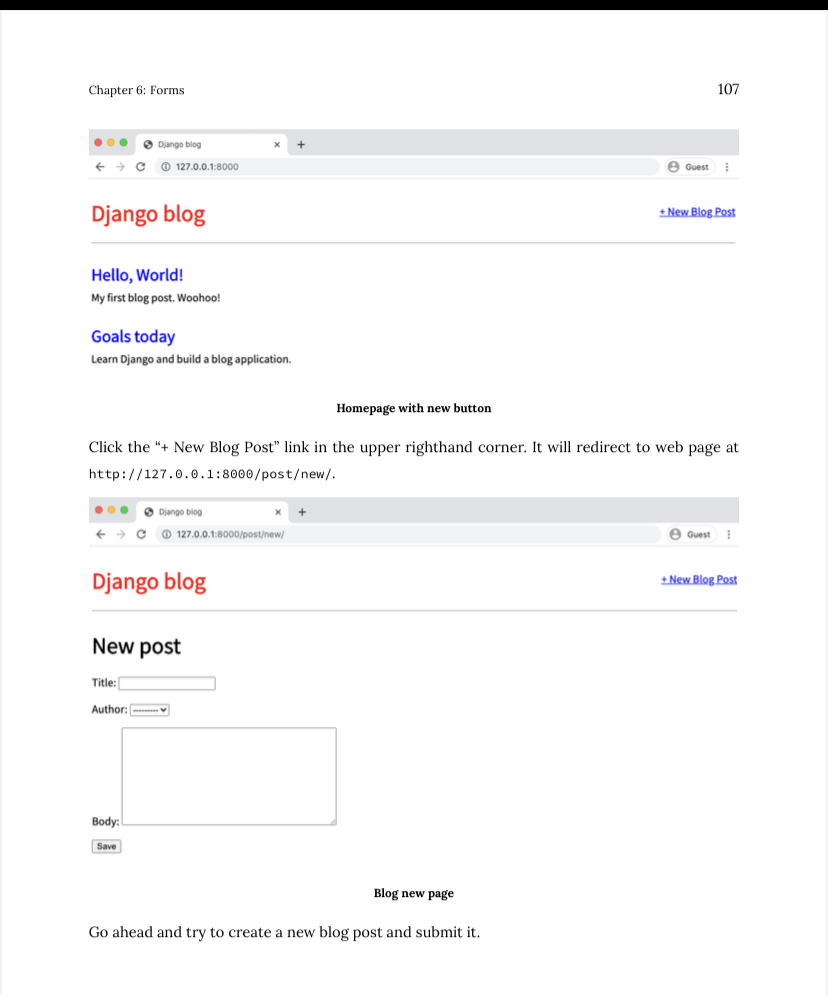

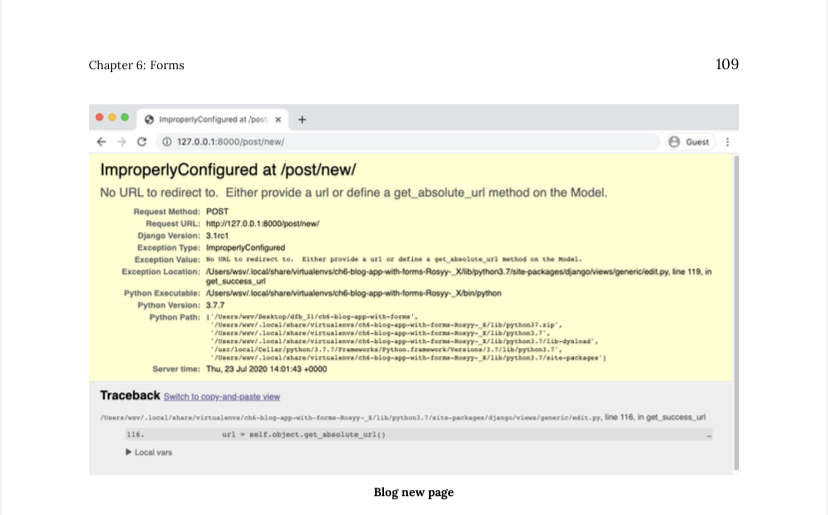

Django’s error message is quite helpful. It’s complaining that we did not specify where to send the user after successfully submitting the form. Let’s send a user to the detail page after success; that way they can see their completed post.
We can follow Django’s suggestion and add a get_absolute_url97 to our model. This is a best practice that you should always do. It sets a canonical URL for an object so even if the structure of your URLs changes in the future, the reference to the specific object is the same. In short, you should add a get_absolute_url() and __str__() method to each model you write.
Open the models.py file. Add an import on the second line for reverse98 and a new get_- absolute_url method.

In [ ]:
# blog/models.py
from django.db import models
from django.urls import reverse # new
class Post(models.Model):
    title = models.CharField(max_length=200) author = models.ForeignKey(
        'auth.User',
        on_delete=models.CASCADE,
    )
    body = models.TextField()

    def __str__(self):
       return self.title

    def get_absolute_url(self): # new
       return reverse('post_detail', args=[str(self.id)])

Reverse99 is a very handy utility function Django provides us to reference an object by its URL template name, in this case post_detail. If you recall, our URL pattern is the following:

In [ ]:
# blog/urls.py
path('post/<int:pk>/', BlogDetailView.as_view(), name='post_detail'),

That means in order for this route to work we must also pass in an argument with the pk (primary key) of the object. Confusingly, pk and id are interchangeable in Django though the Django docs recommend using self.id with get_absolute_url. So we’re telling Django that the ultimate location of a Post entry is its post_detail view which is posts/<int:pk>/ so the route for the first entry we’ve made will be at posts/1.
Try to create a new blog post again at http://127.0.0.1:8000/post/new/.

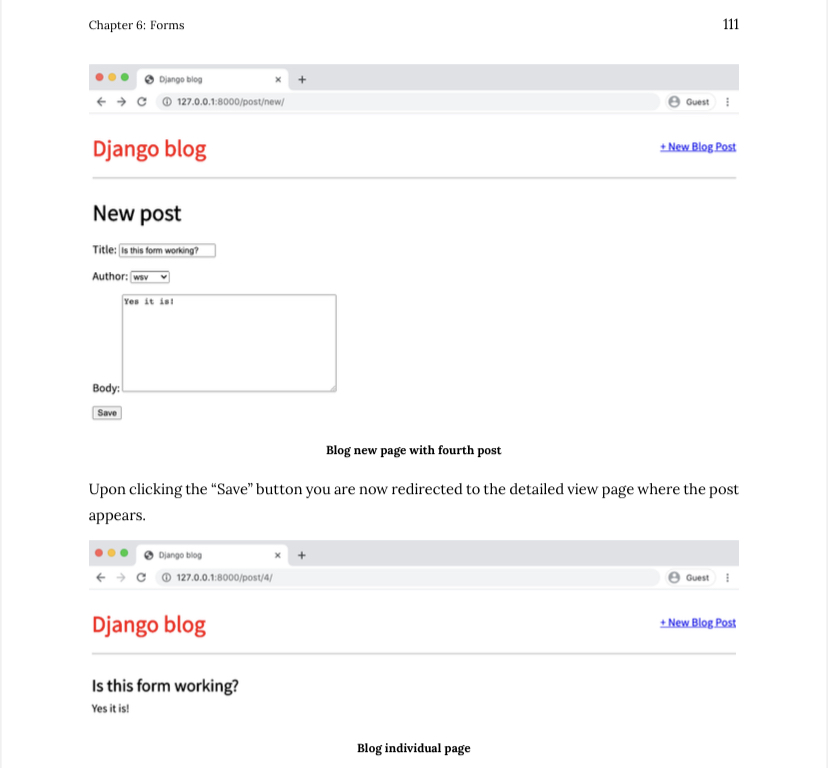

Go over to the homepage at http://127.0.0.1:8000/100 and you’ll also notice that our earlier blog post is also there. It was successfully sent to the database, but Django didn’t know how to redirect us after that.

Go over to the homepage at http://127.0.0.1:8000/100 and you’ll also notice that our earlier blog post is also there. It was successfully sent to the database, but Django didn’t know how to redirect us after that.

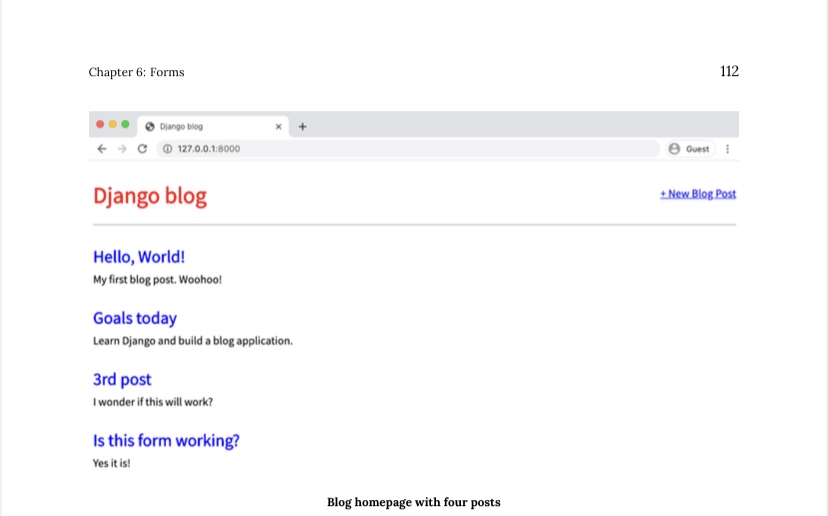

While we could go into the Django admin to delete unwanted posts, it’s better if we add forms
so a user can update and delete existing posts directly from the site.

# Update Form

The process for creating an update form so users can edit blog posts should feel familiar. We’ll
again use a built-in Django class-based generic view, UpdateView101, and create the requisite
template, url, and view.
To start, let’s add a new link to post_detail.html so that the option to edit a blog post appears
on an individual blog page.

In [ ]:
<!-- templates/post_detail.html -->

{% extends 'base.html' %}

{% block content %}
   <div class="post-entry">
       <h2>{{ post.title }}</h2>
       <p>{{ post.body }}</p>
   </div>
   <a href="{% url 'post_edit' post.pk %}">+ Edit Blog Post</a>
{% endblock content %}


We’ve added a link using <a href>...</a> and the Django template engine’s {% url ... %}
tag. Within it, we’ve specified the target name of our url, which will be called post_edit and also
passed the parameter needed, which is the primary key of the post post.pk.
Next we create the template for our edit page called post_edit.html.

Next we create the template for our edit page called post_edit.html.

In [ ]:
(blog) $ touch templates/post_edit.html


And add the following code:

In [ ]:
<!-- templates/post_edit.html -->
{% extends 'base.html' %}
{% block content %}
   <h1>Edit post</h1>
   <form action="" method="post">{% csrf_token %}
      {{ form.as_p }}
   <input type="submit" value="Update">
</form>
{% endblock content %}

We again use HTML <form></form> tags, Django’s csrf_token for security, form.as_p to display
our form fields with paragraph tags, and finally give it the value “Update” on the submit button.
Now to our view. We need to import UpdateView on the second-from-the-top line and then
subclass it in our new view BlogUpdateView.


In [ ]:
# blog/views.py
from django.views.generic import ListView, DetailView
from django.views.generic.edit import CreateView, UpdateView # new
from .models import Post


class BlogListView(ListView):
   model = Post
   template_name = 'home.html'

class BlogDetailView(DetailView):
   model = Post
   template_name = 'post_detail.html'

class BlogCreateView(CreateView):
   model = Post
   template_name = 'post_new.html'
   fields = ['title', 'author', 'body']

class BlogUpdateView(UpdateView): # new
   model = Post
   template_name = 'post_edit.html'
   fields = ['title', 'body']

Notice that in BlogUpdateView we are explicitly listing the fields we want to use ['title',
'body'] rather than using '__all__'. This is because we assume that the author of the post
is not changing; we only want the title and text to be editable.
The final step is to update our urls.py file as follows. Add the BlogUpdateView up top and then
the new route at the top of the existing URLpatterns.


In [ ]:
# blog/urls.py
from django.urls import path
from .views import (
BlogListView,
BlogDetailView,
BlogCreateView,
BlogUpdateView, # new
)


urlpatterns = [
   path('post/<int:pk>/edit/',
      BlogUpdateView.as_view(), name='post_edit'), # new
   path('post/new/', BlogCreateView.as_view(), name='post_new'),
   path('post/<int:pk>/', BlogDetailView.as_view(), name='post_detail'),
   path('', BlogListView.as_view(), name='home'),
]

At the top we add our view BlogUpdateView to the list of imported views, then created a new url
pattern for /post/pk/edit and given it the name post_edit.
Now if you click on a blog entry you’ll see our new Edit button.

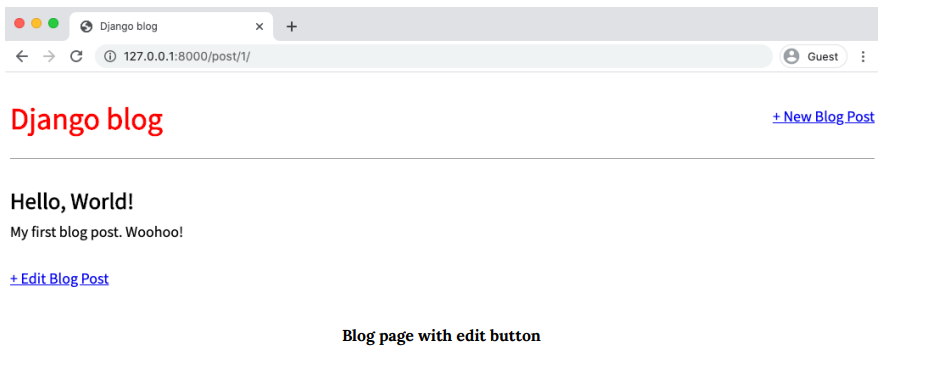

If you click on “+ Edit Blog Post” you’ll be redirected to /post/1/edit/ if it is your first blog post,
hence the 1 in the URL. Note that the form is pre-filled with our database’s existing data for the
post. Let’s make a change…


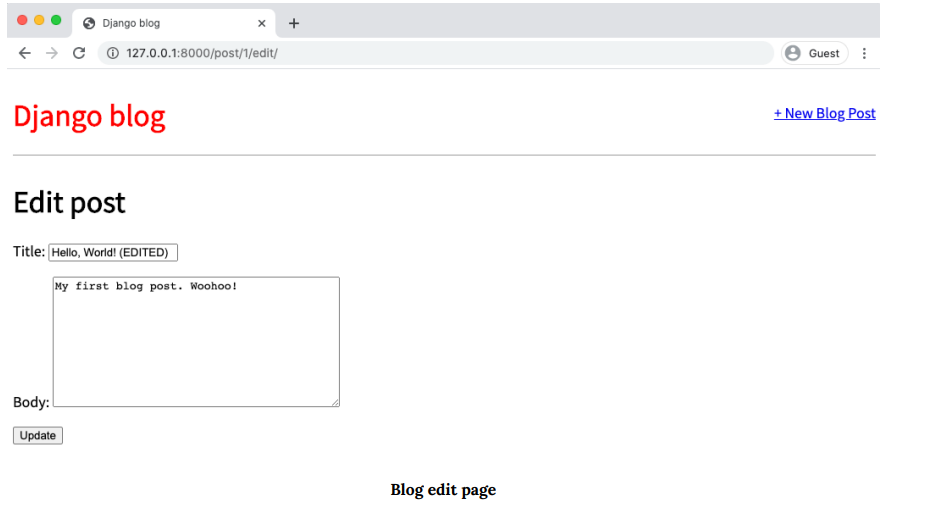

And after clicking the “Update” button we are redirected to the detail view of the post where you
can see the change. This is because of our get_absolute_url setting. Navigate to the homepage
and you can see the change next to all the other entries.


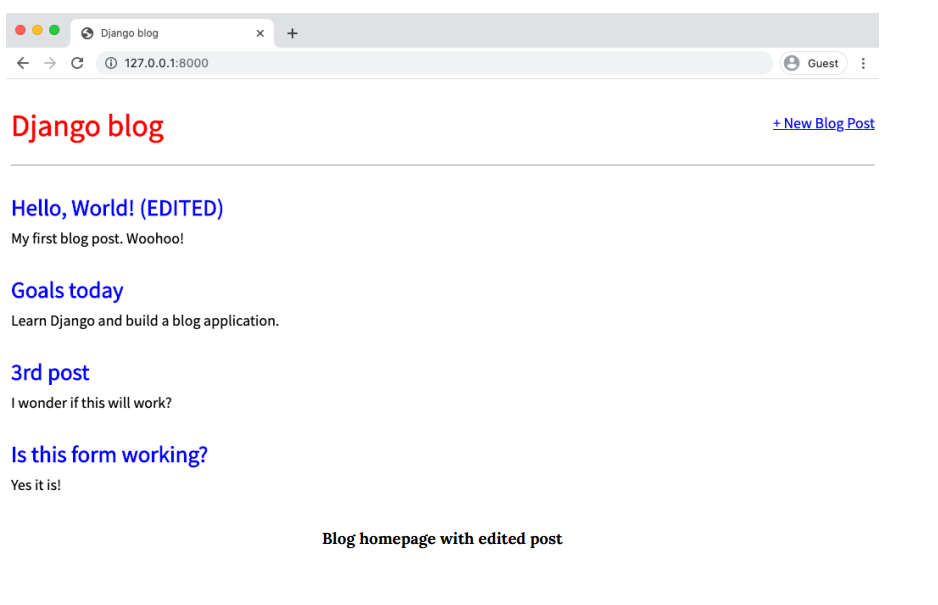

# Delete View

The process for creating a form to delete blog posts is very similar to that for updating a post.
We’ll use yet another generic class-based view, DeleteView102, create the necessary view, url, and
template.
Let’s start by adding a link to delete blog posts on our individual blog page, post_detail.html.

In [ ]:
<!-- templates/post_detail.html -->
{% extends 'base.html' %}

{% block content %}
   <div class="post-entry">
      <h2>{{ post.title }}</h2>
      <p>{{ post.body }}</p>
   </div>
   <p><a href="{% url 'post_edit' post.pk %}">+ Edit Blog Post</a></p>
   <p><a href="{% url 'post_delete' post.pk %}">+ Delete Blog Post</a></p>
{% endblock content %}

Then create a new file for our delete page template. First, quit the local server Control+c and
then type the following command:

In [ ]:
(blog) $ touch templates/post_delete.html

And fill it with this code:

In [ ]:
<!-- templates/post_delete.html -->
{% extends 'base.html' %}

{% block content %}
   <h1>Delete post</h1>
   <form action="" method="post">{% csrf_token %}
     <p>Are you sure you want to delete "{{ post.title }}"?</p>
     <input type="submit" value="Confirm">
   </form>
{% endblock content %}


Note we are using post.title here to display the title of our blog post. We could also just use
object.title as it too is provided by DetailView.
Now update the blog/views.py file, by importing DeleteView and reverse_lazy at the top, then
create a new view that subclasses DeleteView.


In [ ]:
from django.views.generic import ListView, DetailView
from django.views.generic.edit import (
  CreateView, UpdateView, DeleteView
) # new

from django.urls import reverse_lazy # new

from .models import Post

class BlogListView(ListView):
   model = Post
   template_name = 'home.html'

class BlogDetailView(DetailView):
   model = Post
   template_name = 'post_detail.html'

class BlogCreateView(CreateView):
   model = Post
   template_name = 'post_new.html'
   fields = ['title', 'author', 'body']

class BlogUpdateView(UpdateView):
   model = Post
   template_name = 'post_edit.html'
   fields = ['title', 'body']

class BlogDeleteView(DeleteView): # new
   model = Post
   template_name = 'post_delete.html'
   success_url = reverse_lazy('home')


We use reverse_lazy103 as opposed to just reverse104 so that it won’t execute the URL redirect
until our view has finished deleting the blog post.

Finally, create a URL by importing our view BlogDeleteView and adding a new pattern:


In [ ]:
# blog/urls.py
from django.urls import path
from .views import (
   BlogListView,
   BlogDetailView,
   BlogCreateView,
   BlogUpdateView,
   BlogDeleteView, # new
)


urlpatterns = [
   path('post/<int:pk>/delete/', # new
     BlogDeleteView.as_view(), name='post_delete'),
   path('post/new/', BlogCreateView.as_view(), name='post_new'),
   path('post/<int:pk>/', BlogDetailView.as_view(), name='post_detail'),
   path('post/<int:pk>/edit/',
     BlogUpdateView.as_view(), name='post_edit'),
   path('', BlogListView.as_view(), name='home'),
]


If you start the server again with the command python manage.py runserver and refresh any
individual post page you’ll see our “Delete Blog Post” link.

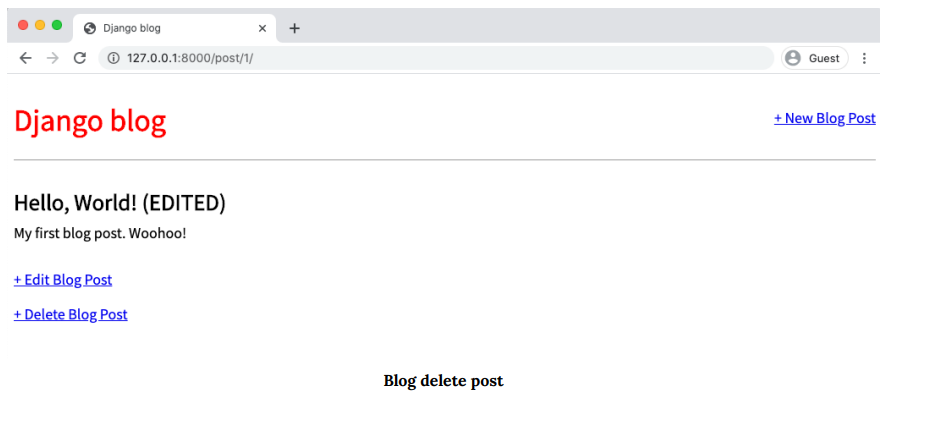

Clicking on the link takes us to the delete page for the blog post, which displays the name of the
blog post.

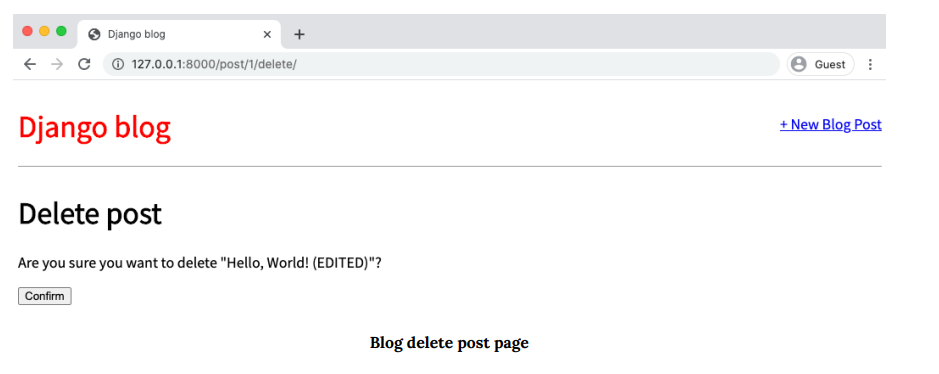

If you click on the “Confirm” button, it redirects you to the homepage where the blog post has
been deleted!

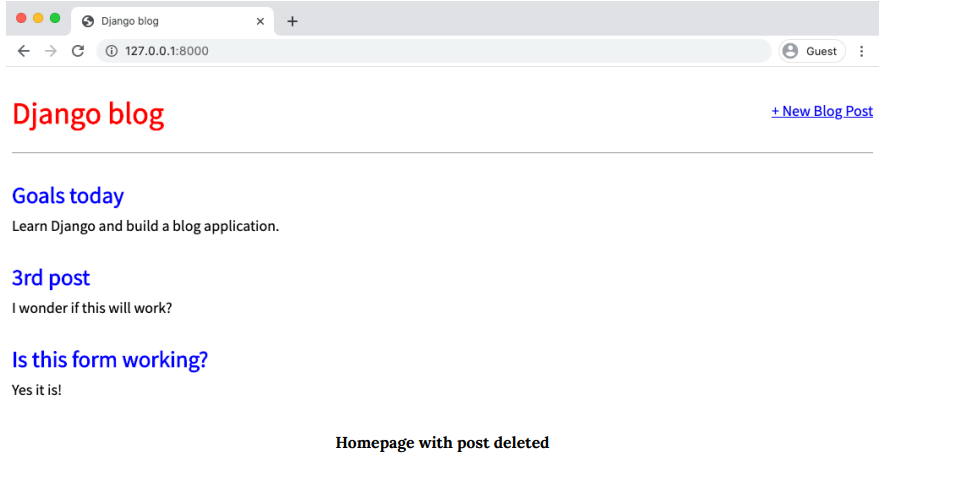

So it works!

# Tests

Time for tests to make sure everything works now–and in the future–as expected. We’ve added
a get_absolute_url method to our model and new views for create, update, and delete posts.
That means we need four new tests:

• def test_get_absolute_url

• def test_post_create_view

• def test_post_update_view

• def test_post_delete_view

Update your existing tests.py file as follows.

In [ ]:
# blog/tests.py
from django.contrib.auth import get_user_model
from django.test import TestCase
from django.urls import reverse
from .models import Post

class BlogTests(TestCase):
   def setUp(self):
      self.user = get_user_model().objects.create_user(
         username='testuser',
         email='test@email.com',
         password='secret'
      )

      self.post = Post.objects.create(
          title='A good title',
          body='Nice body content',
          author=self.user,
      )

    def test_string_representation(self):
        post = Post(title='A sample title')
        self.assertEqual(str(post), post.title)

    def test_get_absolute_url(self): # new
        self.assertEqual(self.post.get_absolute_url(), '/post/1/')

    def test_post_content(self):
        self.assertEqual(f'{self.post.title}', 'A good title')
        self.assertEqual(f'{self.post.author}', 'testuser')
        self.assertEqual(f'{self.post.body}', 'Nice body content')

    def test_post_list_view(self):
        response = self.client.get(reverse('home'))
        self.assertEqual(response.status_code, 200)
        self.assertContains(response, 'Nice body content')
        self.assertTemplateUsed(response, 'home.html')

    def test_post_detail_view(self):
        response = self.client.get('/post/1/')
        no_response = self.client.get('/post/100000/')
        self.assertEqual(response.status_code, 200)
        self.assertEqual(no_response.status_code, 404)
        self.assertContains(response, 'A good title')
        self.assertTemplateUsed(response, 'post_detail.html')

    def test_post_create_view(self): # new
        response = self.client.post(reverse('post_new'), {
            'title': 'New title','body': 'New text','author': self.user.id,
         })
         self.assertEqual(response.status_code, 302)
         self.assertEqual(Post.objects.last().title, 'New title')
         self.assertEqual(Post.objects.last().body, 'New text')

     def test_post_update_view(self): # new
          response = self.client.post(reverse('post_edit', args='1'), {
              'title': 'Updated title','body': 'Updated text',
          })
          self.assertEqual(response.status_code, 302)

      def test_post_delete_view(self): # new
           response = self.client.post(
           reverse('post_delete', args='1'))
           self.assertEqual(response.status_code, 302)



We expect the URL of our test to be at post/1/ since there’s only one post and the 1 is its primary
key Django adds automatically for us. To test create view we make a new response and then
ensure that the response goes through (status code 200) and contains our new title and body
text. For update view we access the first post–which has a pk of 1 which is passed in as the only
argument–and we confirm that it results in a 302 redirect. Finally, we test our delete view by
confirming that if we delete a post, the status code is 302, a redirect since the item no longer
exists.
There’s always more tests that can be added but this at least has coverage on all our new
functionality. Stop the local web server with Control+c and run these tests now. They should
all pass.

In [ ]:
(blog) $ python manage.py test
Creating test database for alias 'default'...
System check identified no issues (0 silenced).
........
----------------------------------------------------------------------
Ran 8 tests in 1.725s
OK
Destroying test database for alias 'default'...


# Conclusion

With a small amount of code we’ve built a Blog application that allows for creating, reading, updating, and deleting blog posts. This core functionality is known by the acronym CRUD: CreateRead-Update-Delete105. While there are multiple ways to achieve this same functionality–we
could have used function-based views or written our own class-based views–we’ve demonstrated how little code it takes in Django to make this happen.
Note, however, a potential security concern: currently any user can update or delete blog entries,
not just the creator! This is not ideal and indeed Django comes with built-in features to restrict
access based on permissions, which we’ll cover in-depth in Chapter 14.

But for now our Blog application is working and in the next chapter we’ll add user accounts so
users can sign up, log in, and log out of the web app.
